In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections 
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [5]:
train = pd.read_csv('./SmartFall Training.csv')
n = 40
X_train, y_train = list(), list()

for i in range(0, len(train)-40):
    temp = list()
    
    temp.append(train[' ms_accelerometer_x'][i : i + n])
    temp.append(train[' ms_accelerometer_y'][i : i + n])
    temp.append(train[' ms_accelerometer_z'][i : i + n])
    
    cnt = collections.Counter(train['outcome'][i: i + n])
    num_adl = cnt[0]
    num_fall = cnt[1]
    
    if num_fall == 25:
        y_train.append(1)
    else:
        y_train.append(0)
    
    X_train.append(temp)

In [3]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(self.relu(out[:, -1]))
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

In [6]:
X_train = np.asarray(X_train).reshape(-1, 40, 3)
y_train = np.asarray(y_train).reshape(-1, )

from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

y_train = enc.fit_transform(y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [7]:
batch_size = 128

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True, batch_size=batch_size)

valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
valid_loader = torch.utils.data.DataLoader(
    valid_data,
    shuffle=True, batch_size=batch_size)

In [8]:
input_dim = next(iter(train_loader))[0].shape[2]
output_dim = 2
n_layers = 2
hidden_dim = 256

lr = 0.0001
n_epochs = 40
iterations_per_epoch = len(train_loader)
best_acc = 0.
patience, trials = 15, 0

model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers).cuda()
print(model)
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epoch_times = []

LSTMNet(
  (lstm): LSTM(3, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
)


In [10]:
print('Start model training')
train_loss, train_acc = list(), list()
for epoch in range(1, n_epochs + 1):
    start_time = time.process_time()
    for i, (X_batch, y_batch) in enumerate(train_loader):
        model.train()
        X_batch = X_batch.float().cuda()
        y_batch = y_batch.cuda()
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
    current_time = time.process_time()
    epoch_times.append(current_time-start_time)
    
    model.eval()
    correct, total = 0, 0
    for x_val, y_val in valid_loader:
        x_val, y_val = [t.cuda() for t in (x_val.float(), y_val)]
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
        
    acc = correct / total
    
    train_loss.append(loss.item())
    train_acc.append(acc)
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')
        
    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'SmartFall_lstm.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
print("Total Training Time: {} seconds".format(str(sum(epoch_times))))

Start model training
Epoch 1 best model saved with accuracy: 94.39%
Epoch 2 best model saved with accuracy: 95.62%
Epoch 3 best model saved with accuracy: 97.52%
Epoch 4 best model saved with accuracy: 97.98%
Epoch:   5. Loss: 0.0371. Acc.: 97.93%
Epoch 6 best model saved with accuracy: 98.02%
Epoch 8 best model saved with accuracy: 98.36%
Epoch 9 best model saved with accuracy: 98.45%
Epoch:  10. Loss: 0.0262. Acc.: 98.39%
Epoch 12 best model saved with accuracy: 98.61%
Epoch:  15. Loss: 0.0359. Acc.: 98.49%
Epoch 16 best model saved with accuracy: 98.65%
Epoch 17 best model saved with accuracy: 98.87%
Epoch:  20. Loss: 0.0150. Acc.: 98.95%
Epoch 20 best model saved with accuracy: 98.95%
Epoch 23 best model saved with accuracy: 99.08%
Epoch:  25. Loss: 0.0197. Acc.: 99.09%
Epoch 25 best model saved with accuracy: 99.09%
Epoch 26 best model saved with accuracy: 99.16%
Epoch 28 best model saved with accuracy: 99.19%
Epoch:  30. Loss: 0.0273. Acc.: 99.02%
Epoch 33 best model saved with a

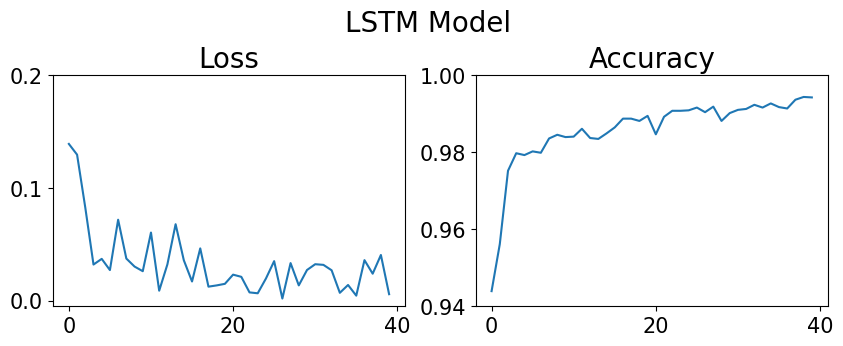

In [11]:
plt.figure(figsize=(10, 3))
plt.suptitle('LSTM Model', fontsize=20, y=1.1)
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_loss)), train_loss)
plt.yticks([0.0, 0.10, 0.20], fontsize=15)
plt.xticks([0, 20, 40], fontsize=15)
plt.title('Loss', fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(train_acc)), train_acc)
plt.yticks([0.94, 0.96, 0.98, 1.0],fontsize=15)
plt.xticks([0, 20, 40], fontsize=15)
plt.title('Accuracy',fontsize=20)
plt.subplots_adjust(hspace=1)

plt.show()

In [10]:
test = pd.read_csv('./SmartFall Testing.csv')

n = 40
X_test_adl, X_test_fall, y_test_adl, y_test_fall = list(), list(), list(), list()
for i in range(0, len(test) - 40):
    temp = list()
    
    temp.append(test[' ms_accelerometer_x'][i : i + n])
    temp.append(test[' ms_accelerometer_y'][i : i + n])
    temp.append(test[' ms_accelerometer_z'][i : i + n])
    
    cnt = collections.Counter(test['outcome'][i : i + n])
    num_adl = cnt[0]
    num_fall = cnt[1]
    
    if num_fall == 25:
        y_test_fall.append(1)
        X_test_fall.append(temp)
    else:
        y_test_adl.append(0)
        X_test_adl.append(temp)

y_test = y_test_adl + y_test_fall
X_test = X_test_adl + X_test_fall

X_test = np.asarray(X_test).reshape(-1, 40, 3)
y_test = np.asarray(y_test).reshape(-1, )

test_data =TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True, batch_size=batch_size)

In [11]:
# evaluation with test dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

targets = list()
preds = list()
correct = 0
model.load_state_dict(torch.load('SmartFall_lstm.pth'))
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.cuda(), y.cuda()
        output = model(X.float())
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(y.view_as(pred)).sum().item()

        targets += list(y.cpu().numpy())
        preds += list(pred.cpu().numpy())

test_acc = 100. * correct / len(test_loader.dataset)
confusion_mtx = confusion_matrix(targets, preds)
print(test_acc)
print(confusion_mtx)
print(classification_report(targets, preds))

99.1657965598725
[[87590   179]
 [  580  2636]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     87769
           1       0.94      0.82      0.87      3216

    accuracy                           0.99     90985
   macro avg       0.96      0.91      0.93     90985
weighted avg       0.99      0.99      0.99     90985



In [9]:
# test
input_dim = 3
output_dim = 2
n_layers = 2
hidden_dim = 256
model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers).to(device)
model.load_state_dict(torch.load('SmartFall_lstm.pth'))

test_df = pd.read_csv('./SmartFall Testing.csv')
n = 40
i = 115
temp = list()
temp.append(test_df[' ms_accelerometer_x'][i : i + n])
temp.append(test_df[' ms_accelerometer_y'][i : i + n])
temp.append(test_df[' ms_accelerometer_z'][i : i + n])
sensor_data = np.asarray(temp).reshape(-1, 40, 3)
sensor_data_bytes = sensor_data.tobytes()

In [14]:
with torch.no_grad():
    sensor_data_from_bytes = np.frombuffer(sensor_data_bytes, dtype=np.float64).reshape(-1,40,3)
    sensor_data_tensor = torch.tensor(sensor_data_from_bytes, dtype=torch.float)
    output = model(sensor_data_tensor.to(device))
    print(output)
    pred = F.log_softmax(output, dim=1).argmax(dim=1)
    print(pred)

tensor([[-0.4782,  0.6536]], device='cuda:0')
tensor([1], device='cuda:0')
